<a href="https://colab.research.google.com/github/s-c-soma/Deeplearning-CMPE-258/blob/main/Assignment_4/Assignment_4_Part_2_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST classifier with various training knobs with Keras

# Implementation Details and Discussion

* Here, I have used MNIST dataset to implement MNIST classifier with various training knobs with Keras
* I have followed all the details mentioned in the **steps** section below.
* I have used Keras Sequential to build NN, first hidden layer used relu activation function with 128 neurons and second hiddden used tanh function with 64 neurons.
* Then, 20 percent neuron were dropped in first hidden layer and 40 percent were dropped in second layer as a part of drop out
* First I tried 100, 50, 30, and 25 epochs. The result is best with the 25 epochs. I did some other hyperparameter tuning inclusing changing batch size also.
* Finally, after 25 epochs the result is:
> loss: 0.0501 - accuracy: 0.9865 - val_loss: 0.3228 - val_accuracy: 0.9936

## Steps:  
Following steps have been followed and implemented in this colab using Keras
* a. Mini-Batch Gradient Descent 
* b. Appropriate/Adaptive Learning Rate
* c. Dropout Regularization Layer
* d. Appropriate Weight Initialization
* e. Image Augmentation
* f. Tuning of Number of Neurons and Layers [3 or more layers]
* g. ReLU Activation Layer
* h. Normalization before training (scaling the input)
* i. Visualization, Validation, Confusion Matrix to show common errors

## Extra Credit:
I have achieved **99% Accuracy** for extra credit


# Check if GPU/TPU available

In [3]:
!nvidia-smi

Wed Apr  7 22:30:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Colab environment

In [4]:
!python --version

Python 3.7.10


In [5]:
!pip list | grep tensor

tensorboard                   2.4.1         
tensorboard-plugin-wit        1.8.0         
tensorflow                    2.4.1         
tensorflow-datasets           4.0.1         
tensorflow-estimator          2.4.0         
tensorflow-gcs-config         2.4.0         
tensorflow-hub                0.11.0        
tensorflow-metadata           0.29.0        
tensorflow-probability        0.12.1        


In [ ]:
!pip list | grep torch

torch                         1.8.0+cu101   
torchsummary                  1.5.1         
torchtext                     0.9.0         
torchvision                   0.9.0+cu101   


# Library

In [32]:
import itertools
import math

import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import ReduceLROnPlateau
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

%matplotlib inline
np.random.seed(42)

# Param Setting

In [39]:
MIN_LEARNING_RATE = 0.00001
TESTING_SIZE = 0.1
EPOCHS = 50
BATCHS = 32

# Load MNIST Data

In [34]:
(X_train, y_train), _ = mnist.load_data()
X_train, y_train = X_train.astype("float32") / 255, y_train.astype("int64")
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=TESTING_SIZE)
X_train, X_valid = np.expand_dims(X_train, axis=-1), np.expand_dims(X_valid, axis=-1)
y_train, y_valid, actual_valid = to_categorical(y_train, num_classes=10), to_categorical(y_valid, num_classes=10), y_valid

# Data Augmentation

In [36]:
# Data Augmentation using Image Data Generator
train_datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1)
train_datagen.fit(X_train)

# Plot Training Image

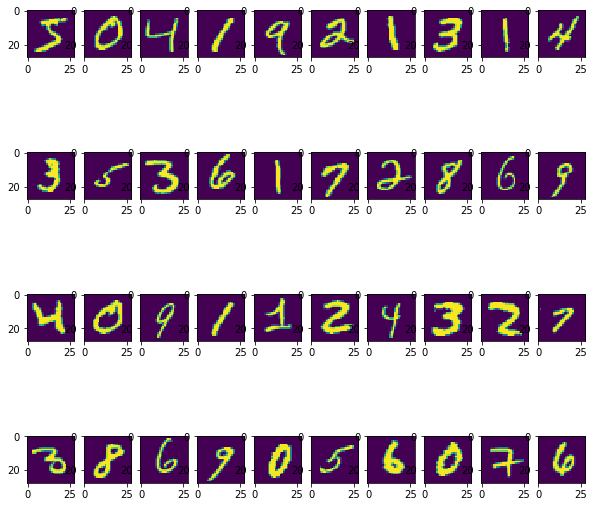

In [26]:
%matplotlib inline
# preview the images first
plt.figure(figsize=(10,10))
x, y = 10, 4
for i in range(40):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i].reshape((28,28)),interpolation='nearest')
plt.show()

# Network Architecture Using Keras

In [35]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding="Same", activation="relu", input_shape=(28, 28, 1)))
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding="Same", activation="relu"))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="Same", activation="relu"))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="Same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)         

# Tuning Learning Rate

In [37]:
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, min_lr=MIN_LEARNING_RATE)

# Training the model

In [48]:
MIN_LEARNING_RATE = 0.00001
TESTING_SIZE = 0.1
EPOCHS = 25
BATCHS = 32

In [49]:
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=BATCHS), steps_per_epoch=math.floor(X_train.shape[0] / BATCHS), epochs=EPOCHS, callbacks=[reduce_lr], validation_data=(X_valid, y_valid))

Epoch 1/25
1687/1687 [==============================] - 20s 12ms/step - loss: 0.0511 - accuracy: 0.9864 - val_loss: 0.3996 - val_accuracy: 0.9828
Epoch 2/25
1687/1687 [==============================] - 21s 12ms/step - loss: 0.0511 - accuracy: 0.9869 - val_loss: 0.3236 - val_accuracy: 0.9843
Epoch 3/25
1687/1687 [==============================] - 20s 12ms/step - loss: 0.0528 - accuracy: 0.9861 - val_loss: 0.3610 - val_accuracy: 0.9843
Epoch 4/25
1687/1687 [==============================] - 20s 12ms/step - loss: 0.0526 - accuracy: 0.9863 - val_loss: 0.3581 - val_accuracy: 0.9838
Epoch 5/25
1687/1687 [==============================] - 20s 12ms/step - loss: 0.0511 - accuracy: 0.9864 - val_loss: 0.4369 - val_accuracy: 0.9828
Epoch 6/25
1687/1687 [==============================] - 20s 12ms/step - loss: 0.0521 - accuracy: 0.9860 - val_loss: 0.3533 - val_accuracy: 0.9842
Epoch 7/25
1687/1687 [==============================] - 20s 12ms/step - loss: 0.0492 - accuracy: 0.9870 - val_loss: 0.3472 -

# Extra Credit: Accuracy 99%

99% Accuracy (Extra Points)

# Visualization

## Plot: Training vs. Validation Accuracy

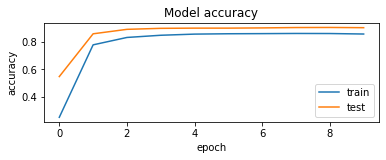

In [ ]:
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Valid Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()

# Display Common Errors

## Confusion Matrix

In [42]:
def plot_confusion_matrix(actual, pred):
    cm = confusion_matrix(actual, pred)
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix")
    plt.colorbar()
    labels = range(10)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

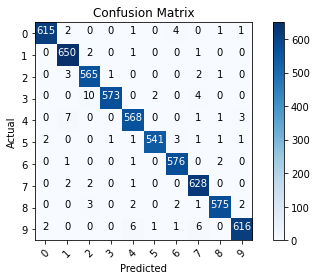

In [43]:
pred_valid = np.argmax(model.predict(X_valid), axis=1) 
plot_confusion_matrix(actual_valid, pred_valid)

## Prediction Error

In [44]:
def show_errors(images, actual, pred):
    errors = pred - actual != 0
    error_images = images[errors]
    error_actual = actual[errors]
    error_pred = pred[errors]
    count, index = len(error_images), 0
    rows, cols = math.ceil(count / 5), 5
    fig, ax = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(20, 50))
    for row in range(rows):
        for col in range(cols):
            if index < count:
                ax[row, col].set_title(f"Actual: {error_actual[index]}\nPredicted: {error_pred[index]}")
                ax[row, col].imshow(error_images[index].reshape((28, 28)))
                index += 1

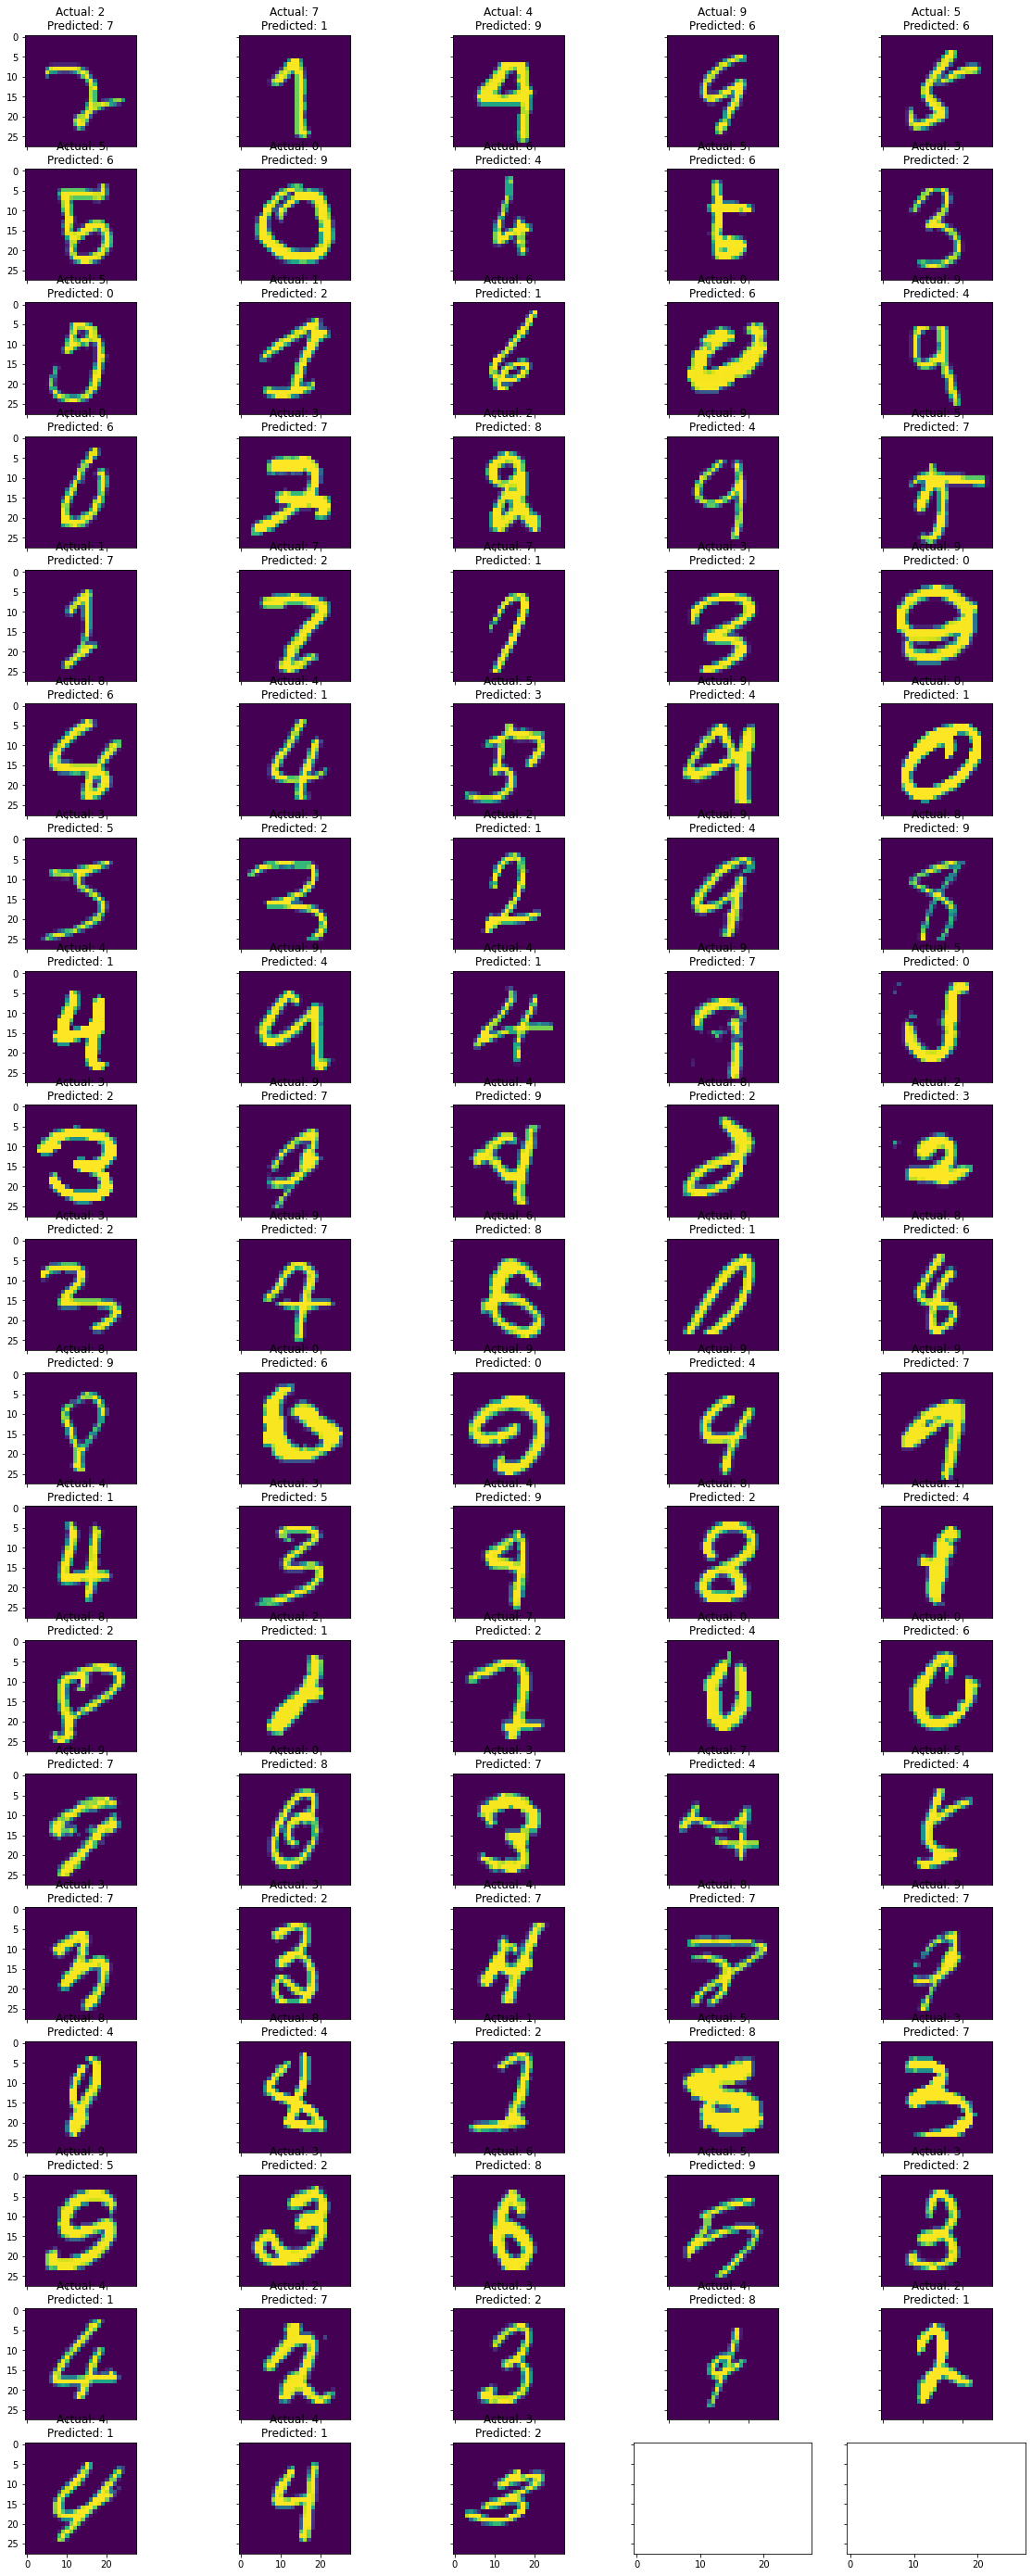

In [45]:
show_errors(X_valid, actual_valid, pred_valid)